In [334]:
import random
import typing as tp

import aiohttp
import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL.Image import Image
from torch import Tensor, nn
from torch.nn import Module as TorchModel
from torch.utils.data import DataLoader as TorchDataLoader
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm import tqdm

В этом соревновании вам предлагается получить наилучшую универсальную атаку на модель ResNet-18 обученную на датасете CIFAR-10

Посылка решений, получение актуального лидерборда, а также бейзлайн будут вам рассказаны по ходу этого ноутбука. 

## Подгрузка данных

Загрузите файл 'train_data.pt' в google collab, он содержит **ваш** набор тренировочных данных, с помощью которых вы должны получить универсальную атаку на модель.

Не забудьте выбрать GPU в Google Collab. Это можно сделать с помощью Runtime -> Change runtime type -> "T4 GPU" -> Save

In [335]:
def load_data(filepath: str) -> TorchDataset:
    loaded_data = torch.load(filepath)

    images_tensor = loaded_data["images"]
    labels_tensor = loaded_data["labels"]

    dataset = TensorDataset(images_tensor, labels_tensor)

    print(f"Subset loaded successfully from {filepath}")
    return dataset

Запуск следующей клетки подгрузит в соотвествующие переменные модель ResNet18, а также часть тренировочного датасета CIFAR-10

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
CLASS_NAMES = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

model: TorchModel = tp.cast(
    TorchModel,
    torch.hub.load(
        "chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True
    ),
)  # resnet18 trained on CIFAR-10 dataset

model.to(DEVICE)

cast_to_tensor: tp.Callable[[Image], Tensor] = (
    transforms.ToTensor()
)  # function to cast image to tensor
cast_to_image: tp.Callable[[Tensor], Image] = transforms.ToPILImage()

cifar10_tensors: TorchDataset[tuple[Tensor, int]] = load_data("train_data.pt")

cifar10_dataloader = TorchDataLoader(
    dataset=cifar10_tensors, batch_size=128, shuffle=False
)

Subset loaded successfully from data/train_data.pt


Using cache found in /home/andrey/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
/tmp/ipykernel_560309/962752015.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

В этой клетке загружается случайный образец из тренировочной выборки для вашего удобства

In [430]:
T = tp.TypeVar("T") # аннотация "дженерик" типа, прямой эквивалент шаблонов из C++


def sample_from_dataset(dataset: TorchDataset[T]) -> T:
    idx = random.randint(0, len(dataset) - 1)  # type: ignore
    return dataset[idx]


example_tensor, example_label = sample_from_dataset(cifar10_tensors)
example_image = cast_to_image(example_tensor)

Максимально допустимая норма атаки сохранена в переменную EPSILON

In [419]:
EPSILON = 4e-2

В следующей клетке содержатся две функции для визуализации случайных сэмплов из датасета

In [338]:
def get_random_image_by_class(dataset: TorchDataset, class_label: int) -> Tensor:
    while True:
        idx = random.randint(0, len(dataset) - 1)  # type: ignore
        image, label = dataset[idx]
        if label == class_label:
            return image


def display_random_image_of_each_class(
    dataset: TorchDataset, figsize: tuple[int, int] = (15, 6)
) -> None:
    nrow = 5

    images: list[Image] = [
        cast_to_image(get_random_image_by_class(dataset, class_label))
        for class_label in range(10)
    ]

    images_tensors: list[Tensor] = [cast_to_tensor(img) for img in images]

    grid = make_grid(images_tensors, nrow=nrow)
    np_grid = grid.permute(
        1, 2, 0
    ).numpy()  # Place channel dimension in correct place for display

    plt.figure(figsize=figsize)  # Adjust figsize as needed for clarity
    plt.imshow(np_grid)
    plt.axis("off")  # Hide axis
    plt.title("Random Image from Each CIFAR-10 Class", fontsize=16)

    grid_height, grid_width, _ = np_grid.shape
    img_height = grid_height // 2
    img_width = grid_width // 5

    for idx, class_label in enumerate(CLASS_NAMES):
        row = idx // nrow
        col = idx % nrow

        # Calculate position for the label
        x = col * img_width + img_width / 2
        y = row * img_height + img_height / 2
        plt.text(
            x,
            y,
            class_label,
            fontsize=12,
            color="white",
            ha="center",
            va="bottom",
            backgroundcolor="black",
        )

    plt.show()


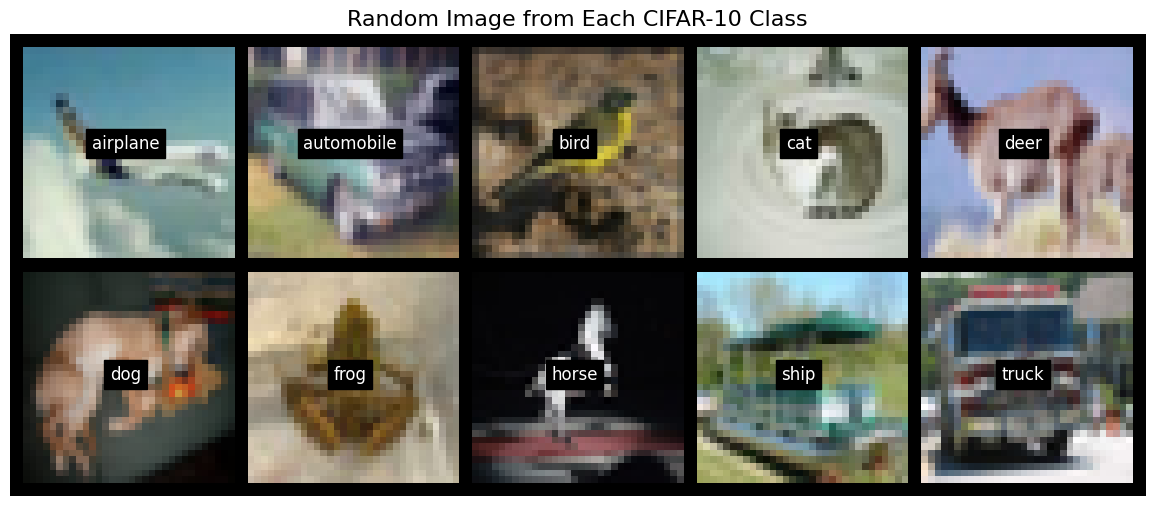

In [339]:
display_random_image_of_each_class(cifar10_tensors)

## Вычисление качества атаки

Конкретный пример применения будет показан дальше

In [374]:
def l_inf_img_norm(img: Tensor) -> float:
    """Evaluate l infinity norm"""
    return torch.max(torch.abs(img)).item()


def check_validity_of_pertubations(
    pertubations: list[Tensor],
    norm_function: tp.Callable[[Tensor], float] = l_inf_img_norm,
    max_norm: float = EPSILON,
) -> bool:
    """
    Check whether the norm of each pertubation is within bounds
    """
    for pert in pertubations:
        if norm_function(pert) > max_norm:
            return False

    return True


def score_adversarial_attack(
    pertubations: list[Tensor],
    model: torch.nn.Module,
    dataloader: TorchDataLoader,
    device: torch.device,
) -> float:
    """
    Score is evaluated as a percent of samples on which model changed its predictions("fooling ratio")
    Attack is successful if at least one of passed pertubations changes prediction of the model
    """

    model.eval()

    num_samples = len(dataloader.dataset)  # type: ignore

    attack_results: list[Tensor] = []

    with torch.no_grad():
        original_preds_list = []
        for images, _ in tqdm(dataloader, desc="Evaluating original predictions"):
            images = images.to(device)
            logits = model(images)  # Shape: [batch_size, num_classes]
            preds = logits.argmax(dim=1)  # Shape: [batch_size]
            original_preds_list.append(preds.cpu())

        original_preds = torch.cat(original_preds_list, dim=0)  # Shape: [num_samples]

        for pert_idx, pert in enumerate(pertubations):
            pert = pert.to(device)  # just in case

            fooled_mask = torch.zeros(num_samples, dtype=torch.bool)
            offset = 0  # Tracks position in the fooled_mask

            for images, _ in tqdm(
                dataloader,
                desc=f"Evaluating attacked predictions on {pert_idx} pertubation",
            ):
                batch_size = images.size(0)

                images = images.to(device)

                attacked_images = images + pert.to(device)

                attacked_logits = model(attacked_images)
                attacked_preds = attacked_logits.argmax(dim=1).cpu()  # [batch_size]

                # Compare with the corresponding original predictions
                original_batch_preds = original_preds[offset : offset + batch_size]
                fooled_batch = attacked_preds.ne(original_batch_preds)  # bool tensor

                fooled_mask[offset : offset + batch_size] = fooled_batch
                offset += batch_size

            attack_results.append(fooled_mask)

    all_fooled_tensor = torch.stack(attack_results, dim=0)
    fooled_by_any = all_fooled_tensor.any(dim=0)  # Logical OR

    num_fooled_samples = fooled_by_any.sum().item()
    fooling_ratio = num_fooled_samples / num_samples

    return fooling_ratio

## Первый бейзлайн: случайная атака

Сгенерируем 2 случайные атаки

In [375]:
random_attacks = [torch.rand(3, 32, 32) * EPSILON for _ in range(3)]

Проверим что норма каждой атаки не превосходит порог 

In [413]:
check_validity_of_pertubations(random_attacks)

True

Вычислим качество атаки на тестовой выборке как долю атакованных примеров, на которых модель изменила свое предсказание

In [377]:
score_on_random_attack = score_adversarial_attack(
    random_attacks, model, cifar10_dataloader, DEVICE
)
print(f"Score on random pertubations: {score_on_random_attack}")

Evaluating attacked predictions on 2 pertubation: 100%|██████████| 21/21 [00:00<00:00, 214.37it/s]


Score on random pertubations: 0.1482490272373541


## Посылка решения в тестирующую систему

Взаимодействие с тестирующей системой осуществляется с помощью 4х асинхронных методов:
- `register` - регистрация в тестирующей системе
- `get_leaderboard` - получить текущий лидерборд, где указана лучшая посылка для каждого пользователя
- `get_submission_history` - получить историю "скоров" ваших посылок
- `submit` - сделать посылку вашего решения в тестирующую систему

В переменную USERNAME укажите название вашей команды, а в переменную PASSWORD укажите пароль 

In [378]:
USERNAME: str = ...
PASSWORD: str = ...

Следующая клетка содержит функции для взаимодействия с тестирующей системой. Их использование будет показано чуть дальше

In [ ]:
BASE_URL = "http://127.0.0.1:8000"


async def register(username: str = USERNAME, passwd: str = PASSWORD) -> None:
    """
    Calls the /register endpoint to create a new user.
    Raises ValueError if registration fails.
    """
    endpoint = f"{BASE_URL}/register?username={username}&password={passwd}"
    async with aiohttp.ClientSession() as session:
        res = await session.post(endpoint)  # (no JSON body here)
        if res.status != 200:
            content = await res.text()
            raise ValueError(f"Registration failed: {content}")
        print(await res.json())


async def get_leaderboard() -> pd.DataFrame:
    """
    Calls the /leaderboard endpoint and returns a DataFrame
    with columns [user, score].
    """
    endpoint = f"{BASE_URL}/leaderboard"
    async with aiohttp.ClientSession() as session:
        res = await session.get(endpoint)
        if res.status != 200:
            content = await res.text()
            raise ValueError(f"Error getting leaderboard: {content}")
        data = await res.json()
        leaderboard = data["leaderboard"]
        df = pd.DataFrame(leaderboard, columns=["user", "score"])
        return df


async def get_submission_history(username: str = USERNAME) -> list[float]:
    """
    Calls the /submissions_history endpoint with the given username
    and returns that user's history of submission scores as a list[float].
    """
    endpoint = f"{BASE_URL}/submissions_history"

    async with aiohttp.ClientSession() as session:
        # Pass the username as a query parameter
        res = await session.get(endpoint, params={"username": username})
        if res.status != 200:
            content = await res.text()
            raise ValueError(f"Error getting submissions history: {content}")
        data = await res.json()
        return data["history"]


async def submit(
    perturbations: list[Tensor], username: str = USERNAME, passwd: str = PASSWORD
) -> float:
    """
    Calls the /submit endpoint (requires Basic Auth).
    Uploads each tensor in the `perturbations` list as an image file
    in a multipart/form-data request. Returns the score from the server.
    """

    if not isinstance(perturbations, list) or not all(
        isinstance(pert, Tensor) for pert in perturbations
    ):
        raise ValueError(
            "Pertubations have wrong type, you need to pass list of torch.Tensor"
        )

    endpoint = f"{BASE_URL}/submit"
    form_data = aiohttp.FormData()

    for i, tensor in enumerate(perturbations):
        file_bytes = tensor.cpu().numpy().tobytes()
        form_data.add_field(
            name="files",
            value=file_bytes,
            filename=f"file_{i}.bin",
            content_type="application/octet-stream",
        )

    # Send request with BasicAuth
    async with aiohttp.ClientSession() as session:
        res = await session.post(
            endpoint, data=form_data, auth=aiohttp.BasicAuth(username, passwd)
        )
        if res.status != 200:
            content = await res.text()
            raise ValueError(f"Error submitting perturbations: {content}")
        data = await res.json()
        return data["score"]


Все эти 4 функции - **асинхронные**, это значит что для их выполнения нужно обязательно добавлять ключевое слово await

Выполните следующую клетку, чтобы тестирующая система запомнила вас

In [416]:
await register()

ValueError: Registration failed: {"detail":"Username already exists"}

Функцию register() нужно запустить ровно один раз, если вызвать ее еще раз, тестирующая система вернет ошибку, так как уже знает вас

В следующей клетке пример засылки вашего решения в тестирующую систему. Вам нужно отправить лист из не более двух тензоров с адверсальной атакой, у каждого из которого норма меньше EPSILON

In [384]:
await submit(random_attacks)

0.109

С помощью функции get_leaderboard можно получить текущий лидерборд с лучшими посылками на текущий момент от всех участников соревнования

In [385]:
await get_leaderboard()

,user,score
0,admin,0.109


Функция get_submission_history возвращает лист со "скорами" успешных посылок в прошлом 

In [386]:
await get_submission_history()

[0.109]

## Второй бейзлайн: метод SGD

Далее представлена реализация универсальной адверсальной атаки с помощью метода стохастического градиентного спуска.
Детально о нем можно прочитать в статье: https://openaccess.thecvf.com/content_cvpr_2017/papers/Moosavi-Dezfooli_Universal_Adversarial_Perturbations_CVPR_2017_paper.pdf

In [387]:
def clamped_crossentropy_loss(
    outputs: Tensor, targets: Tensor, loss_fn: nn.Module, beta_tensor: torch.Tensor
) -> Tensor:
    per_sample_loss = loss_fn(outputs, targets)
    clipped = torch.minimum(per_sample_loss, beta_tensor)
    return clipped.mean()


def uap_sgd(
    model: nn.Module,
    loader: TorchDataLoader,
    nb_epoch: int,
    eps: float = EPSILON,
    beta: float = 12.0,
    step_decay: float = 0.8,
    loss_fn=None,
    uap_init: Tensor | None = None,
) -> tuple[Tensor, list[float]]:
    device = next(model.parameters()).device
    model.eval()

    # Get shape from the first batch
    x_val, y_val = next(iter(loader))
    x_val, y_val = x_val.to(device), y_val.to(device)

    if uap_init is None:
        # shape [C,H,W] from the first sample
        delta = torch.zeros_like(x_val[0], device=device)
    else:
        delta = uap_init.to(device).clone()

    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss(reduction="none")

    beta_tensor = torch.tensor([beta], device=device, dtype=torch.float32)

    losses: list[float] = []
    eps_step = eps * step_decay  # initial step size

    for epoch in range(nb_epoch):
        print(f"Epoch {epoch + 1}/{nb_epoch}")
        for i, (x_batch, y_batch) in tqdm(enumerate(loader), total=len(loader)):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Create a fresh batch_delta each time, sized for this batch
            current_batch_size = x_batch.size(0)
            batch_delta = delta.unsqueeze(0).repeat(current_batch_size, 1, 1, 1)
            batch_delta.requires_grad_(True)

            # Forward pass
            perturbed = torch.clamp(x_batch + batch_delta, 0, 1)
            outputs = model(perturbed)

            # Compute loss
            c_loss = clamped_crossentropy_loss(outputs, y_batch, loss_fn, beta_tensor)
            loss = c_loss
            losses.append(loss.item())

            # Backprop
            loss.backward()

            # Average gradient across batch dimension
            grad_mean = batch_delta.grad.mean(dim=0).sign()

            # Update `delta` in-place, but do it inside no_grad
            with torch.no_grad():
                delta += grad_mean * eps_step
                delta.clamp_(-eps, eps)

        # Optional: decaying step size each epoch
        eps_step *= step_decay

    return delta.detach(), losses


In [421]:
sgd_attack, loss_history = uap_sgd(model, cifar10_dataloader, 2)

Epoch 1/2


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:00<00:00, 56.32it/s]


Epoch 2/2


100%|██████████| 21/21 [00:00<00:00, 74.67it/s]


In [422]:
score_on_sgd_attack = score_adversarial_attack(
    [sgd_attack], model, cifar10_dataloader, DEVICE
)
print(f"Score of universal attack via sgd method: {score_on_sgd_attack}")

Evaluating attacked predictions on 0 pertubation: 100%|██████████| 21/21 [00:00<00:00, 182.42it/s]

Score of universal attack via sgd method: 0.8011673151750973


In [423]:
await submit([sgd_attack])

0.813

In [424]:
await get_leaderboard()

,user,score
0,user1,0.814
1,admin,0.813


In [425]:
await get_submission_history()

[0.109, 0.813, 0.813]

## Визуализация адверсальной атаки

In [404]:
def visualize_result_of_attack(img: Tensor, attack: Tensor, model: nn.Module) -> None:
    model.eval()
    img = img.to(DEVICE)
    attack = attack.to(DEVICE)
    # 1) Predict on the original image
    with torch.no_grad():
        logits_original = model(img.unsqueeze(0))  # shape [1, 10]
        pred_original = logits_original.argmax(dim=1).item()

    # 2) Generate the attacked image and predict
    attacked_img = (img + attack).clamp(0, 1)
    with torch.no_grad():
        logits_attacked = model(attacked_img.unsqueeze(0))  # shape [1, 10]
        pred_attacked = logits_attacked.argmax(dim=1).item()

    # 3) Convert Tensors -> PIL for visualization
    pil_original = cast_to_image(img.cpu())
    pil_attacked = cast_to_image(attacked_img.cpu())

    # 4) Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(pil_original)
    axes[0].set_title(f"Original: {CLASS_NAMES[pred_original]}")
    axes[0].axis("off")

    axes[1].imshow(pil_attacked)
    axes[1].set_title(f"Attacked: {CLASS_NAMES[pred_attacked]}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


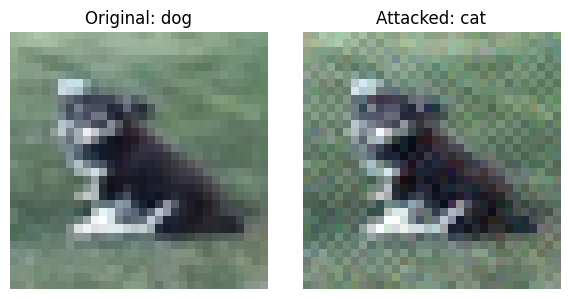

In [426]:
visualize_result_of_attack(example_tensor, sgd_attack, model)

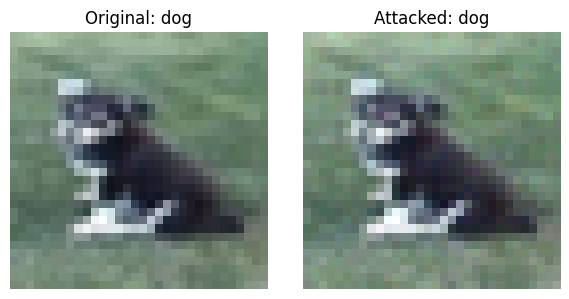

In [427]:
visualize_result_of_attack(example_tensor, random_attacks[0], model)

## Ваши эксперименты

Если при засылке появляется ошибка - читайте ее содержание! Скорее всего вы просто делаете неправильную посылку

In [431]:
# TODO: your code